We bring the imports we need

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, SimpleRNN, Dropout
from keras.optimizers import Adam
from keras.regularizers import L2
from keras.callbacks import ReduceLROnPlateau


## Load dataset

We will use *yFincance* to get the data from *Microsoft*

In [196]:
end = datetime.now()
start = datetime(2019, end.month, end.day)
dataset = yf.download("MSFT", start, end)
dataset.shape


[*********************100%%**********************]  1 of 1 completed


(1259, 6)

## Inspect dataset

Let's see the dataset that we have

In [197]:
dataset.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-03-18,414.250000,420.730011,413.779999,417.320007,417.320007,20106000
2024-03-19,417.829987,421.670013,415.549988,421.410004,421.410004,19837900
2024-03-20,422.000000,425.959991,420.660004,425.230011,425.230011,17860100
2024-03-21,429.829987,430.820007,427.160004,429.369995,429.369995,21296200
2024-03-22,429.700012,429.859985,426.070007,428.739990,428.739990,17636500


Here we remove the last row and we save it in a new variable to use it to compare predicted price with the last price we have in the last row.

In [198]:
actual_close = dataset.iloc[-1]['Close']
dataset.drop(dataset.index[-1], inplace=True)



Let's check for null data

In [199]:
dataset.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

We will check what type of data are the columns from dataset

In [200]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-03-25 to 2024-03-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1258 non-null   float64
 1   High       1258 non-null   float64
 2   Low        1258 non-null   float64
 3   Close      1258 non-null   float64
 4   Adj Close  1258 non-null   float64
 5   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.8 KB


Let's check for duplicates

In [201]:
dataset.duplicated().sum()

0

Let's observe the dataset in a plot

/usr/local/Caskroom/miniconda/base/envs/stock-prediction-env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/Caskroom/miniconda/base/envs/stock-prediction-env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


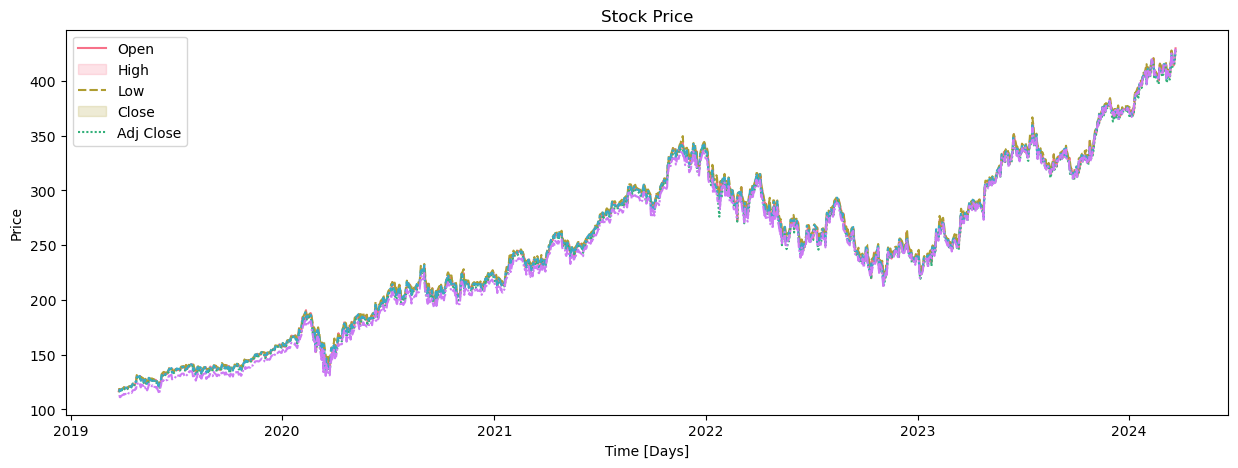

In [202]:
plt.figure(figsize=(15, 5))
palette = sns.color_palette("husl", 5)
sns.lineplot(data=dataset[['Open', 'High', 'Low', 'Close', 'Adj Close']],palette=palette) 
plt.title('Stock Price')
plt.xlabel('Time [Days]')
plt.ylabel('Price')
plt.legend(labels=['Open', 'High', 'Low', 'Close', 'Adj Close'], loc='best')
plt.show()

In [203]:
original_dataset = dataset

## Transform the data

We normalize the data

In [204]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset['Close'].values.reshape(-1, 1))

Splitting the data
X_train, y_train: Training set, used to train the model.

We sets the number of time steps to 50, meaning each sequence will contain 50 data points.
X_train_seq, y_train_seq = create_time_steps(X_train, time_steps): This creates sequences for the training data (X_train_seq contains input sequences, and y_train_seq contains corresponding labels).
X_val_seq, y_val_seq = create_time_steps(X_val, time_steps): This creates sequences for the validation data.
X_test_seq, y_test_seq = create_time_steps(X_test, time_steps): This creates sequences for the test data.

In [205]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Create sequences with a length of 10 (you can adjust this)
sequence_length = 20
X, y = create_sequences(scaled_data, sequence_length)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


We create a method **Learning rate Plateau** in case we need to use it, this will decrease the learning rate

In [206]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

## Create Model RNN Sequential LSTM

We create a sequential model using an LSTM layer followed by 4 Dense output layers
we are predicting the future value of the 'Close' price.

In [207]:
model = Sequential([
    LSTM(units=128, input_shape=(sequence_length, 1)),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

We create a function to save the model when it reach the best performaces, based on the validation loss.

In [208]:
from keras.callbacks import ModelCheckpoint
def create_checkpoint(model_path):

   model_checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
   return model_checkpoint
    

Define the optimizer and compile the model

In [209]:
learning_rate = 0.001
# Compile the model
model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=120, batch_size=32 ,validation_data=(X_test, y_test), callbacks=[create_checkpoint('ModelLSTM.h5')])

Epoch 1/120


30/31 [============================>.] - ETA: 0s - loss: 0.0281
Epoch 1: val_loss improved from inf to 0.01303, saving model to ModelLSTM.h5
31/31 [==============================] - 4s 33ms/step - loss: 0.0273 - val_loss: 0.0130
Epoch 2/120
11/31 [=========>....................] - ETA: 0s - loss: 0.0017

/usr/local/Caskroom/miniconda/base/envs/stock-prediction-env/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - ETA: 0s - loss: 0.0010
Epoch 2: val_loss improved from 0.01303 to 0.00064, saving model to ModelLSTM.h5
31/31 [==============================] - 0s 15ms/step - loss: 0.0010 - val_loss: 6.3627e-04
Epoch 3/120
30/31 [============================>.] - ETA: 0s - loss: 6.1043e-04
Epoch 3: val_loss improved from 0.00064 to 0.00059, saving model to ModelLSTM.h5
31/31 [==============================] - 0s 16ms/step - loss: 6.0366e-04 - val_loss: 5.9236e-04
Epoch 4/120
28/31 [==========================>...] - ETA: 0s - loss: 5.6768e-04
Epoch 4: val_loss did not improve from 0.00059
31/31 [==============================] - 0s 14ms/step - loss: 5.5570e-04 - val_loss: 0.0015
Epoch 5/120
30/31 [============================>.] - ETA: 0s - loss: 5.4459e-04
Epoch 5: val_loss did not improve from 0.00059
31/31 [==============================] - 0s 15ms/step - loss: 5.4198e-04 - val_loss: 0.0020
Epoch 6/120
29/31 [===========================>..] - ETA: 0s - loss:

We load the model with the best validation loss.

In [210]:
model = tf.keras.models.load_model('ModelLSTM.h5')

We evaluate the model.

In [211]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

print(f'Training Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

Training Loss: 0.00020602656877599657
Test Loss: 0.00023001393128652126


Inverse transform the predictions

In [212]:
# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Inverse transform the actual values
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 [==============================] - 0s 5ms/step


We plot the prediction and the initial data

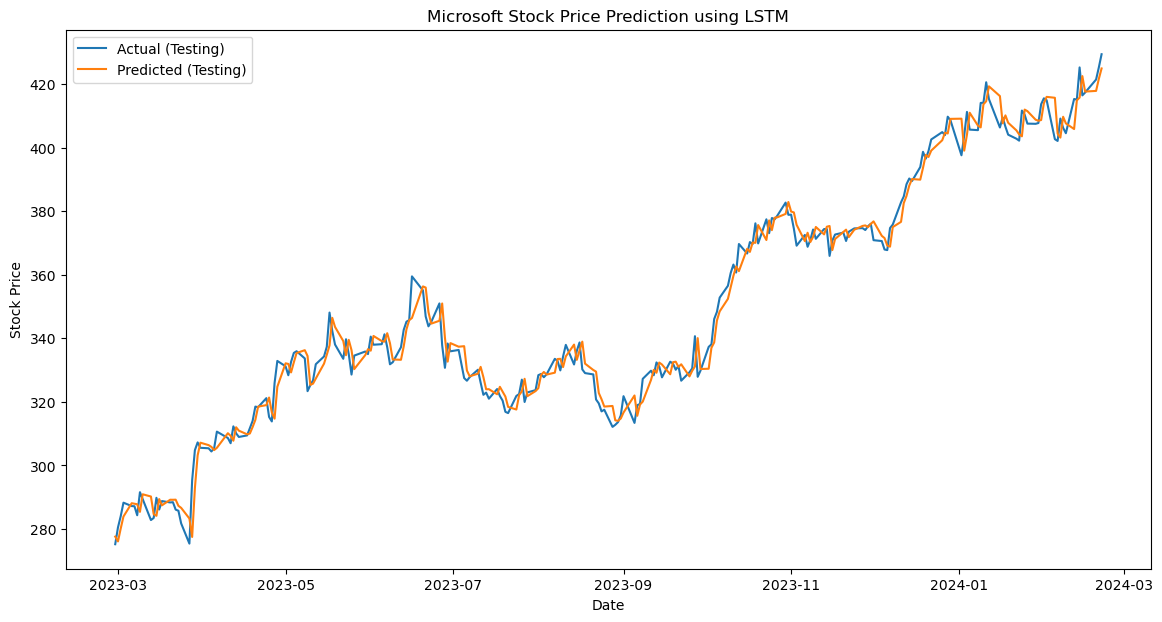

In [213]:
# Plotting
plt.figure(figsize=(14, 7))
#plt.plot(dataset.index[:len(y_train_inv)], y_train_inv, label='Actual (Training)')
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(y_test_inv)], y_test_inv, label='Actual (Testing)')
#plt.plot(dataset.index[:len(train_predict)], train_predict, label='Predicted (Training)')
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(test_predict)], test_predict, label='Predicted (Testing)')
plt.title('Microsoft Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## GRU model

We will create a GRU model to see how it will perform

In [214]:
gru_model = Sequential([
    GRU(units=128, input_shape=(sequence_length, 1)),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

Define optimizer and compile the model

Model training

In [215]:
learning_rate = 0.001
# Compile the model
gru_model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')

# Train the model
gru_model.fit(X_train, y_train, epochs=120, batch_size=32 ,validation_data=(X_test, y_test), callbacks=[create_checkpoint('ModelGRU.h5')])

Epoch 1/120
30/31 [============================>.] - ETA: 0s - loss: 0.0241
Epoch 1: val_loss improved from inf to 0.00084, saving model to ModelGRU.h5
31/31 [==============================] - 4s 33ms/step - loss: 0.0234 - val_loss: 8.3759e-04
Epoch 2/120
11/31 [=========>....................] - ETA: 0s - loss: 5.9993e-04

/usr/local/Caskroom/miniconda/base/envs/stock-prediction-env/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - ETA: 0s - loss: 4.3917e-04
Epoch 2: val_loss improved from 0.00084 to 0.00051, saving model to ModelGRU.h5
31/31 [==============================] - 0s 15ms/step - loss: 4.3917e-04 - val_loss: 5.0855e-04
Epoch 3/120
30/31 [============================>.] - ETA: 0s - loss: 3.1501e-04
Epoch 3: val_loss improved from 0.00051 to 0.00045, saving model to ModelGRU.h5
31/31 [==============================] - 0s 16ms/step - loss: 3.1882e-04 - val_loss: 4.4676e-04
Epoch 4/120
31/31 [==============================] - ETA: 0s - loss: 2.9077e-04
Epoch 4: val_loss did not improve from 0.00045
31/31 [==============================] - 0s 13ms/step - loss: 2.9077e-04 - val_loss: 4.5495e-04
Epoch 5/120
29/31 [===========================>..] - ETA: 0s - loss: 2.5964e-04
Epoch 5: val_loss improved from 0.00045 to 0.00038, saving model to ModelGRU.h5
31/31 [==============================] - 0s 16ms/step - loss: 2.6117e-04 - val_loss: 3.7734e-04
Epoch 6/120
31/31 [==

We load the model

In [216]:
gru_model = tf.keras.models.load_model('ModelGRU.h5')

Evaluate the model.

In [217]:
# Evaluate the model
train_loss = gru_model.evaluate(X_train, y_train, verbose=0)
test_loss = gru_model.evaluate(X_test, y_test, verbose=0)

print(f'Training Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

Training Loss: 0.00021841743728145957
Test Loss: 0.00023777750902809203


Scale the data to initial state

In [218]:
# Predictions
gru_train_predict = gru_model.predict(X_train)
gru_test_predict = gru_model.predict(X_test)

# Inverse transform the predictions
gru_train_predict = scaler.inverse_transform(gru_train_predict)
gru_test_predict = scaler.inverse_transform(gru_test_predict)

# Inverse transform the actual values
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 [==============================] - 0s 4ms/step


Plot the prediction and the initial data

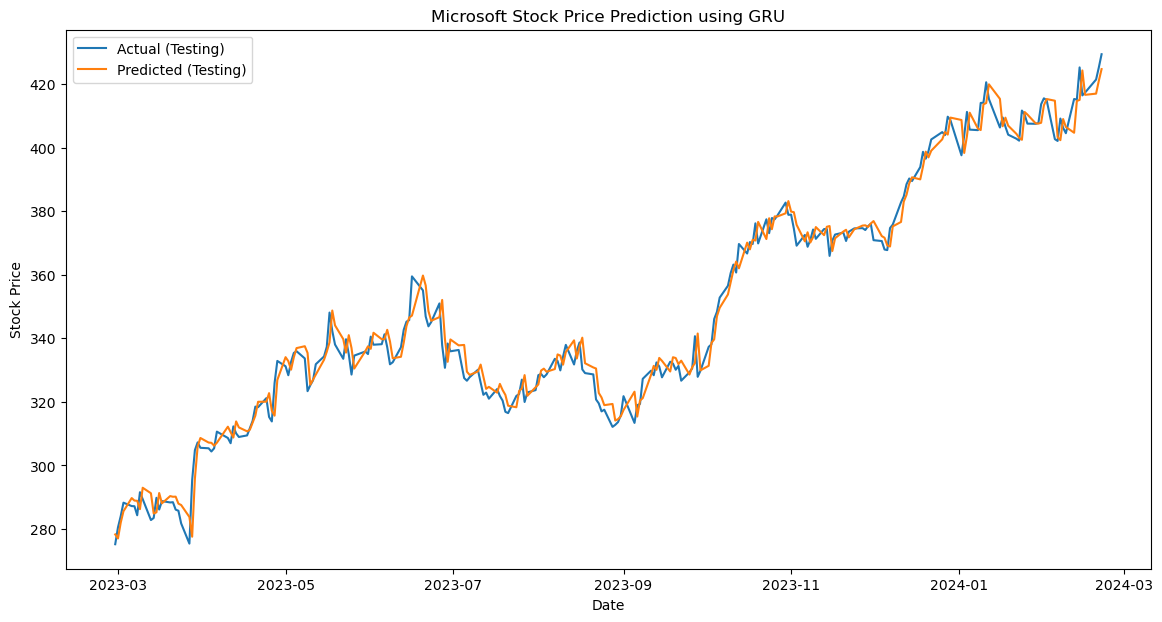

In [219]:
# Plotting
plt.figure(figsize=(14, 7))
#plt.plot(dataset.index[:len(y_train_inv)], y_train_inv, label='Actual (Training)')
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(y_test_inv)], y_test_inv, label='Actual (Testing)')
#plt.plot(dataset.index[:len(train_predict)], train_predict, label='Predicted (Training)')
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(gru_test_predict)], gru_test_predict, label='Predicted (Testing)')
plt.title('Microsoft Stock Price Prediction using GRU')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## RNN Simple model

In [220]:
rnn_model = Sequential([
    SimpleRNN(units=128, input_shape=(sequence_length, 1)),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

Define optimizers, compile and train the model.

In [221]:
learning_rate = 0.001
# Compile the model
rnn_model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')

# Train the model
rnn_model.fit(X_train, y_train, epochs=120, batch_size=32 ,validation_data=(X_test, y_test), callbacks=[create_checkpoint('ModelSimpleRNN.h5')])

Epoch 1/120
22/31 [====================>.........] - ETA: 0s - loss: 0.0272
Epoch 1: val_loss improved from inf to 0.00626, saving model to ModelSimpleRNN.h5
31/31 [==============================] - 2s 16ms/step - loss: 0.0200 - val_loss: 0.0063
Epoch 2/120
22/31 [====================>.........] - ETA: 0s - loss: 7.7160e-04

/usr/local/Caskroom/miniconda/base/envs/stock-prediction-env/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.00626 to 0.00192, saving model to ModelSimpleRNN.h5
31/31 [==============================] - 0s 8ms/step - loss: 7.3461e-04 - val_loss: 0.0019
Epoch 3/120
23/31 [=====================>........] - ETA: 0s - loss: 4.2935e-04
Epoch 3: val_loss improved from 0.00192 to 0.00096, saving model to ModelSimpleRNN.h5
31/31 [==============================] - 0s 10ms/step - loss: 4.2366e-04 - val_loss: 9.6033e-04
Epoch 4/120
23/31 [=====================>........] - ETA: 0s - loss: 3.7818e-04
Epoch 4: val_loss did not improve from 0.00096
31/31 [==============================] - 0s 6ms/step - loss: 4.6849e-04 - val_loss: 0.0064
Epoch 5/120
23/31 [=====================>........] - ETA: 0s - loss: 4.9866e-04
Epoch 5: val_loss did not improve from 0.00096
31/31 [==============================] - 0s 6ms/step - loss: 5.0082e-04 - val_loss: 0.0024
Epoch 6/120
23/31 [=====================>........] - ETA: 0s - loss: 7.1327e-04
Epoch 6: val_loss did not improve from 0.000

Load the model.

In [222]:
rnn_model = tf.keras.models.load_model('SimpleRNNmodel.h5')

Evaluate the model.

In [223]:
# Evaluate the model
train_loss = rnn_model.evaluate(X_train, y_train, verbose=0)
test_loss = rnn_model.evaluate(X_test, y_test, verbose=0)

print(f'Training Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

Training Loss: 0.00019576195336412638
Test Loss: 0.00023074673663359135


In [224]:
# Predictions
rnn_train_predict = rnn_model.predict(X_train)
rnn_test_predict = rnn_model.predict(X_test)

# Inverse transform the predictions
rnn_train_predict = scaler.inverse_transform(rnn_train_predict)
rnn_test_predict = scaler.inverse_transform(rnn_test_predict)

# Inverse transform the actual values
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 [==============================] - 0s 2ms/step


Plot the model.

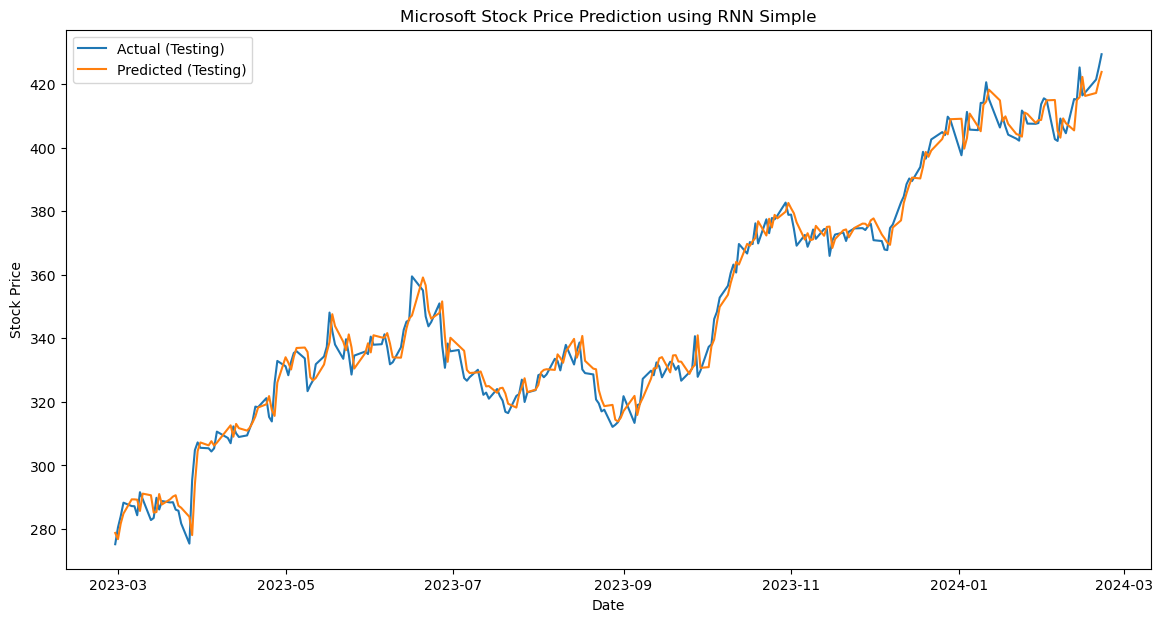

In [225]:
# Plotting
plt.figure(figsize=(14, 7))
#plt.plot(dataset.index[:len(y_train_inv)], y_train_inv, label='Actual (Training)')
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(y_test_inv)], y_test_inv, label='Actual (Testing)')
#plt.plot(dataset.index[:len(train_predict)], train_predict, label='Predicted (Training)')
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(rnn_test_predict)], rnn_test_predict, label='Predicted (Testing)')
plt.title('Microsoft Stock Price Prediction using RNN Simple')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Let's compare all 3 models with actual price from today.

In [226]:
last_predicted_close_lstm = test_predict[-1][0]
last_predicted_close_gru = gru_test_predict[-1][0]
last_predicted_close_rnn = rnn_test_predict[-1][0]

print("Actual price: ", actual_close)
print("LSTM Prediction: ", last_predicted_close_lstm)
print("GRU Prediction: ", last_predicted_close_gru)
print("RNN Prediction: ", last_predicted_close_rnn)

Actual price:  428.739990234375
LSTM Prediction:  424.8942
GRU Prediction:  424.6861
RNN Prediction:  423.79684


Here we try to predict Close price for the next 10 days

In [228]:
# To predict for the next 10 days, you'll need the last n_past days of data
last_sequence = X_test[-1]

# Reshape the last_sequence to match the input shape of the model
last_sequence = last_sequence.reshape(1, sequence_length, 1)

# Generate predictions for the next 10 days
predictions_next_10_days = []
for _ in range(10):
    next_day_prediction = model.predict(last_sequence, verbose=0)
    predictions_next_10_days.append(next_day_prediction[0, 0])  # Get the predicted value
    last_sequence = np.roll(last_sequence, -1, axis=1)  # Shift the sequence by one day
    last_sequence[0, -1, 0] = next_day_prediction  # Update the last element with the new prediction

# Transform the predictions back to the original scale
predictions_next_10_days = scaler.inverse_transform(np.array(predictions_next_10_days).reshape(-1, 1))

# Print the predictions for the next 10 days
print("Predictions for the next 10 days:")
for i, prediction in enumerate(predictions_next_10_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")

/var/folders/0h/qswpgy_95n36fhs64cbccqcc0000gn/T/ipykernel_76771/292049606.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_sequence[0, -1, 0] = next_day_prediction  # Update the last element with the new prediction


Predictions for the next 10 days:
Day 1: Predicted Price = 424.8941650390625
Day 2: Predicted Price = 425.30126953125
Day 3: Predicted Price = 425.820068359375
Day 4: Predicted Price = 426.3769226074219
Day 5: Predicted Price = 426.9852294921875
Day 6: Predicted Price = 427.6383056640625
Day 7: Predicted Price = 428.32696533203125
Day 8: Predicted Price = 429.0413513183594
Day 9: Predicted Price = 429.7730407714844
Day 10: Predicted Price = 430.51495361328125
